# Homework for statistics module

Rules for code style:
* All the code in this notebook
* Imports are provided in the head of the notebook
* All the cells could be ran in the right order from the top to the bottom
* Commentaries are required
* All the plots should have: title, axis labels and summaries (if necessary)
* Main summaries are provided in cells using markdown **(your analysis of the results and data is very important!!!)**
* Try to use functions and classes to reduce duplicated code blocks to minimum

Also you can use $\LaTeX$ to write formulas. F.e. $\bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i$ or on a new line:
$$
    \bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i
$$
To do so, you can write anything between $\$ \quad \$$ (or  $ \$\$ \quad\$\$ $).

### Criteria (50 points total):
* Task 1 (17 points)

    * Requested formulas are provided - 4 points
    * All necessary experiments are done - 6 points
    * Results are analysed with commentaries - 7 points
* Tasks 2.1 и 2.2 (16 points)

    * Visualization and/or simple exploratory data analysis are implemented - 2 points
    * Hypotheses are tested - 2 points
    * Results are analysed with commentaries - 4 points
* Task 3 (13 points)

    * Visualization and/or simple exploratory data analysis are implemented - 2 points
    * Hypotheses are tested - 4 points
    * Data was aggregated properly - 2 points
    * Results are analysed with commentaries - 5 points
* Extra points:

    * 4 points in case clear, "pythonic" and understandable code style.

Good work: 40+ points.

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')  
# from matplotlib import style
#style.use('seaborn')

from pylab import rcParams

# plots in svg look more precise
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter('ignore')

from scipy.stats import chi2_contingency
from scipy.stats import chi2
from numpy import cov
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

# Task 1

## Stratification

The example:

Let's assume, we need to estimate a mean votes count for every election candidate. Suppose there are 3 cities in a country: 1 million factory workers live in city A, 2 million office workers live in city B, and 3 million senior citizens live in city B. We can choose a random sample of 60 votes from the entire population, but there is some chance that the random sample will be poorly balanced between these cities and, therefore, will be biased and of little use ("average temperature in the hospital"), causing a significant error in the estimation. Instead, if we choose to use a simple random sample of 10, 20 and 30 votes from cities A, B and C, respectively, we can get a smaller error in the estimate with the same total sample size. This technique is called stratification.


### The task

Suppose the population is a mixture of 3 normally distributed CBs. In other words, the population can be divided into 3 strata.
$$
    F(X) = a_1 F(X_1) + a_2 F(X_2) + a_3 F(X_3)
$$

**Goals:**  

1. Derive (for example, in the block below, using Markdown) the formulas for point estimates of the mathematical expectation and variance for the average value of subsamples formed in different ways:
- random selection from the entire population;
- random selection of strata in proportion to strata volumes;
- random selection according to the optimal sub-sampling.

2. Calculate point estimates of the mathematical expectation and variance of the mean value for each data sampling method from p.1, provided:
* Experiments should be conducted for 3 cases (for every method from p.1 each):
     * all strata have the same mat. expectations and variance;
     * strata have different mat. expectations, but the same variance;
     * strata have different mat. expectations and variance.
* For each sampling method plot histogram of General Population data (using matplotlib or seaborn packages);
* Plot boxplots for sample mean estimated using each sampling method on a single figure to compare the results. Repeat for each experiment.
* You are provided with `GeneralPopulation` class. It already has all necessary methods for sampling and creating general population as a mixture of strata.
* Your goal is to write functions to conduct experiments and visualize the results.   
* Also provide commentaries as summaries and analysis of results after each visualization.


## Solution for Task 1

### Formulas:

#### Stratified sample point estimations:

 **Mathematical expectation**

<img src="https://i.imgur.com/Ub2iKqX.png" width="400">

 **Variance**

<img src="https://i.imgur.com/AvfGL8D.png" width="400">



#### Sample volumes if they are sampled proportionally:

`HERE ARE YOUR FORMULAS DERIVED`

#### Sample volumes if they are optimal sampled (Neyman's method):

<img src="https://i.imgur.com/HYDGroE.jpeg" width="500">

**GeneralPopulation class**  
Already has methods for creating general population as a mixture of strata, for generating subsample with random, optimal and stratified techniques:

In [ ]:
class GeneralPopulation:

  def __init__(self, 
               means: [float], 
               stds: [float], 
               sizes: [int], 
               random_state: int = 15
               ):
    """
    Initializes our General Population and saves the given distributions
    
    :param means: List of expectations for normal distributions
    :param stds: List of standard deviations for normal distributions
    :param sizes: How many objects will be in each strata
    :param random_state: Parameter fixing randomness. Needed so that when conducting
    experiment repeatedly with the same input parameters, the results remained the same
    """
    self.strats = [st.norm(mean, std) for mean, std in zip(means, stds)]
    self._sample(sizes)
    self.random_state = random_state

  def _sample(self, sizes):
        """Creates a general population sample as a mixture of strata
        
        :param sizes: List with sample sizes of the corresponding normal distributions
        """
        self.strats_samples = [rv.rvs(size) for rv, size in zip(self.strats, sizes)]
        self.general_samples = np.hstack(self.strats_samples)
        self.N = self.general_samples.shape[0]
        
        # number of strata
        self.count_strats = len(sizes)
        
        # ratios for every strata in GP
        self.ws = [size/self.N for size in sizes]
        
        # ME and Std for GP
        self.m = np.mean(self.general_samples)
        self.sigma = np.std(self.general_samples)
        
        # ME and std for all strata
        self.ms = [np.mean(strat_sample) for strat_sample in self.strats_samples]
        self.sigmas = [np.std(strat_sample) for strat_sample in self.strats_samples]

  def random_subsampling(self, size):
      """Creates a random subset of the entire population
      
      :param sizes: subsample size
      """
      rc = np.random.choice(self.general_samples, size=size) 
      return rc
      
  def proportional_subsampling(self, size):
      """Creates a subsample with the number of elements, proportional shares of strata
      
      :param sizes: subsample size
      """
      self.strats_size_proport = [int(np.floor(size*w)) for w in self.ws]
      
      rc = []
      for k in range(len(self.strats_size_proport)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_proport[k]))
      
      return rc
      
  def optimal_subsampling(self, size):
      """Creates a subsample with the optimal number of elements relative to strata
      
      :param sizes: subsample size
      """
      sum_denom = 0
      for k in range(self.count_strats):
          sum_denom += self.ws[k] * self.sigmas[k]
      
      self.strats_size_optimal = [int(np.floor((size*w*sigma)/sum_denom)) for w, sigma in zip(self.ws, self.sigmas)]
      if 0 in self.strats_size_optimal:
          raise ValueError('Strats size is 0, please change variance of smallest strat!')
      
      rc = []
      for k in range(len(self.strats_size_optimal)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_optimal[k]))
      
      return rc   

  def run_experiments(self, n_sub, subsampling_method, n_experiments=1000):
      """Conducts a series of experiments and saves the results
      
      :param subsampling_method: method for creating a subsample
      :param n_experiments: number of experiment starts
      """
      means_s = []
      
      if (len(self.general_samples)<100):
          n_sub = 20
      
      if (subsampling_method == 'random_subsampling'):
          for n in range(n_experiments):
              rc = self.random_subsampling(n_sub)
              
              mean = rc.sum()/len(rc)
              means_s.append(mean)
              
      else:
          for n in range(n_experiments):
              if(subsampling_method == 'proportional_subsampling'):
                  rc = self.proportional_subsampling(n_sub)
              elif(subsampling_method == 'optimal_subsampling'):
                  rc = self.optimal_subsampling(n_sub)
              
              strats_mean = []
      
              for k in range(len(rc)):
                  strats_mean.append(sum(rc[k])/len(rc[k]))
      
              # Mean for a mixture
              means_s.append(sum([w_k*mean_k for w_k, mean_k in zip(self.ws, strats_mean)]))
              
      return means_s

Function for histogram plot:

In [531]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Uses matplotlib or seaborn packages to plot distribution for general population;
* Don't forget a title, grid etc. 
"""

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution of general population") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
    ax_hist.legend()

    plt.show()


Function for plotting Boxplots for sample mean:

In [535]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Runs method `run_experiments` for each sampling method and gets vector of mean values;
* Uses matplotlib or seaborn packages to plot boxplots of mean values for each subsampling techniques;
* Axis X == Mean values; Axis Y == subsampling methods;
* Don't forget a title, grid etc. 
"""

def draw_boxplot(gp, num_subs):
    methods = ['random_subsampling', 'proportional_subsampling', 'optimal_subsampling']
    output = []
    for method in methods:
        res = gp.run_experiments(n_sub=num_subs, subsampling_method=method)
        output.append(res)

    data = [output[0],output[1], output[2]]
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_subplot(111)
    plt.title("Mean of different subsampling methods") 
    plt.xlabel("Mean values")

    # Creating axes instance
    bp = ax.boxplot(data, patch_artist = True,
                    notch ='True', vert = 0)
    
    colors = ['#0000FF', '#00FF00',
              '#FFFF00']
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")
    
    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)
    
    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='red',
                  linewidth = 3)
    
    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
                  color ='#e7298a',
                  alpha = 0.5)
        
    # x-axis labels
    ax.set_yticklabels([methods[0], methods[1],
                        methods[2]])
    
    # Removing top axes and right axes
    # ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
        
    # show plot
    plt.show(bp)
    plt.show()

**Parameters for each General Population**  
You can use these or specify your own parameters for strata:

In [442]:
SIZES = (150, 150, 150)
N_SUBSAMPLE = 150
EQUAL_MEAN_EQUAL_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 3, 3], 'sizes': SIZES}
DIFFERENT_MEAN_EQUAL_STDS_ARGS = {'means': [15, -1, -17], 'stds': [3, 3, 3], 'sizes':SIZES}
EQUAL_MEAN_DIFFERENT_STDS_ARGS = {'means': [0, 5, 8], 'stds': [3, 7, 11], 'sizes':SIZES}

**Initialization**

In [ ]:
# sample sizes of the corresponding normal distributions
sizes2 = (50, 50, 50)

EQUAL MEANS and EQUAL STDS

In [ ]:
# Create GeneralPopulation class instances here
gp_eq_mean_eq_std = GeneralPopulation(means=[0, 0, 0], stds=[3, 3, 3], sizes=SIZES, random_state=25) 
gp_eq_mean_eq_std._sample(sizes2) 
samp_eq_mean_eq_std = gp_eq_mean_eq_std.random_subsampling(N_SUBSAMPLE)

DIFFERENT MEAN and EQUAL STDS

In [ ]:
gp_diff_mean_eq_std = GeneralPopulation(means=[15, -1, -17], stds=[3, 3, 3], sizes=SIZES, random_state=25)
gp_diff_mean_eq_std._sample(sizes2) 
samp_diff_mean_eq_std = gp_diff_mean_eq_std.random_subsampling(N_SUBSAMPLE) 

DIFFERENT MEAN and DIFFERENT STDS

In [443]:
gp_diff_mean_diff_std = GeneralPopulation(means=[0, 0, 0], stds=[3, 7, 11], sizes=SIZES, random_state=25)
gp_diff_mean_diff_std._sample(sizes2) 
samp_diff_mean_diff_std = gp_diff_mean_diff_std.random_subsampling(N_SUBSAMPLE) 

**General population with EQUAL means and EQUAL STDs of strata**  
Distribution histogram:

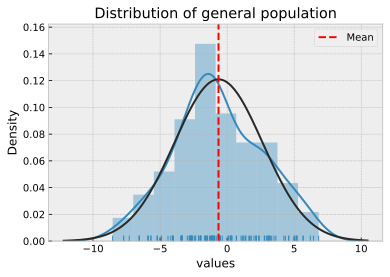

In [532]:
# Run plotting for density

draw_histogram(samp_eq_mean_eq_std)

**Normality Tests**  
1) Shapiro-Wilk Test  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.  

In [564]:
def shapiro_normality_testing(data):
  stat, p = shapiro(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably Gaussian')
  else:
    print('Probably not Gaussian')

In [565]:
shapiro_normality_testing(samp_eq_mean_eq_std)

stat=0.987, p=0.191
Probably Gaussian


2) *D’Agostino’s K^2 Test*  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.

In [555]:
def norm_test(data):
  stat, p = normaltest(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably Gaussian')
  else:
    print('Probably not Gaussian')

In [556]:
norm_test(samp_eq_mean_eq_std)

stat=1.390, p=0.499
Probably Gaussian


3)*Anderson-Darling Test*  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.

In [568]:
def anderson_normality_testing(data):
  result = anderson(data)
  print('stat=%.3f' % (result.statistic))
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
      print('Probably Gaussian at the %.1f%% level' % (sl))
    else:
      print('Probably not Gaussian at the %.1f%% level' % (sl))

In [569]:
anderson_normality_testing(samp_eq_mean_eq_std)

stat=0.626
Probably not Gaussian at the 15.0% level
Probably Gaussian at the 10.0% level
Probably Gaussian at the 5.0% level
Probably Gaussian at the 2.5% level
Probably Gaussian at the 1.0% level


Boxplots for sample mean:

No handles with labels found to put in legend.


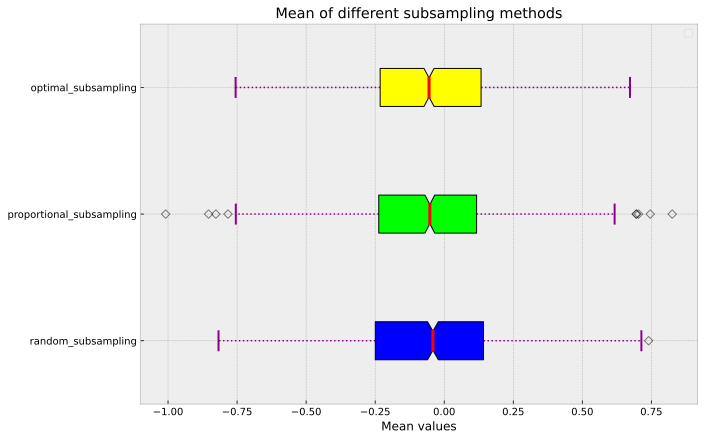

In [525]:
# Run plotting for boxplots
draw_boxplot(gp_eq_mean_eq_std, N_SUBSAMPLE)


**Conclusion**

* The presented distribution is normal. This fact is also confirmed by tests.
* Looking at boxplots, we can say that the "proportional_subsampling" method has noticeable outliers.
* Looking at destribution - median is about -1

**General population with DIFFERENT means and EQUAL STDs of strata**  
Distribution histogram:

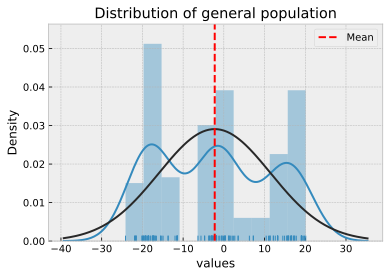

In [533]:
# Run plotting for density

draw_histogram(samp_diff_mean_eq_std)

**Normality Tests**  
1) Shapiro-Wilk Test  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.  

In [566]:
shapiro_normality_testing(samp_diff_mean_eq_std)

stat=0.911, p=0.000
Probably not Gaussian


2) *D’Agostino’s K^2 Test*  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.


In [557]:
norm_test(samp_diff_mean_eq_std)

stat=133.547, p=0.000
Probably not Gaussian


3)*Anderson-Darling Test*  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.


In [570]:
anderson_normality_testing(samp_diff_mean_eq_std)

stat=4.262
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


Boxplots for sample mean:

No handles with labels found to put in legend.


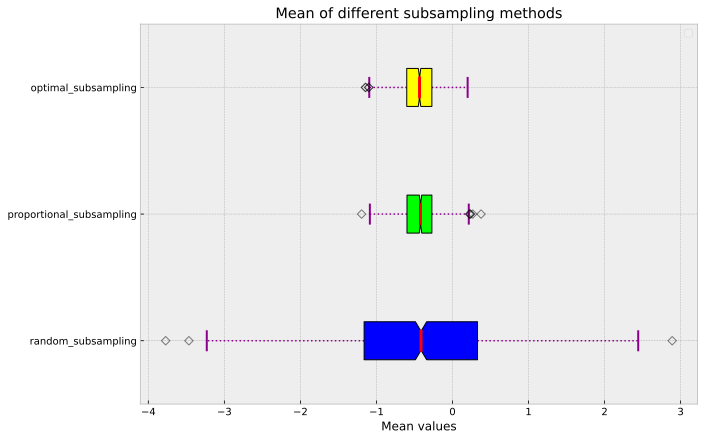

In [526]:
# Run plotting for boxplots


draw_boxplot(gp_diff_mean_eq_std, N_SUBSAMPLE)

**Conclusion**
* The presented distribution is not a normal one. This fact is also confirmed by tests.
* Looking at boxplots, we can say that the all subsampling methods have noticeable outliers.
* Looking at destribution - median is about -1

**General population with DIFFERENT means and DIFFERENT STDs of strata**  
Distribution histogram:

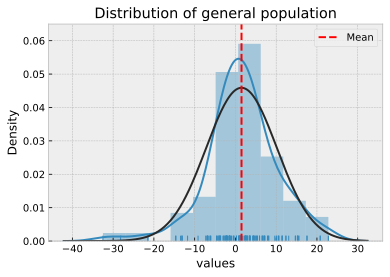

In [534]:
# Run plotting for density

draw_histogram(samp_diff_mean_diff_std)

**Normality Tests**  
1) Shapiro-Wilk Test  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution. 


In [567]:
shapiro_normality_testing(samp_diff_mean_diff_std)

stat=0.958, p=0.000
Probably not Gaussian


2) *D’Agostino’s K^2 Test*  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.


In [558]:
norm_test(samp_diff_mean_diff_std)

stat=16.471, p=0.000
Probably not Gaussian


3)*Anderson-Darling Test*  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.


In [571]:
anderson_normality_testing(samp_diff_mean_diff_std)


stat=1.665
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


Boxplots for sample mean:

No handles with labels found to put in legend.


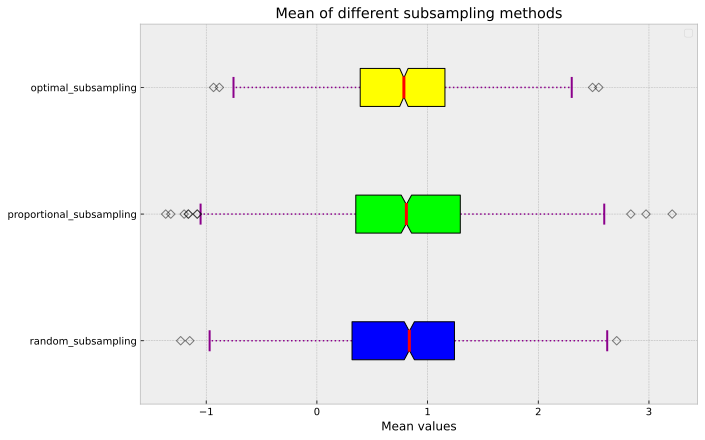

In [527]:
# Run plotting for boxplots

draw_boxplot(gp_diff_mean_diff_std, N_SUBSAMPLE)

**Conclusion**
* The presented distribution is not a normal one. This fact is also confirmed by tests.
* From about -40 to -20, we can observe outliers, the average values are slightly shifted to the right, while the distribution has a right tail.
* Looking at boxplots, we can say that the all subsampling methods have noticeable outliers.
* Looking at destribution - median is about 1

# Task 2



### Part 1
Using [this criteria](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward.), check whether there is a correlation between a brain size and intelligence for a dataset consisted both of men and women objects. Also check it for men and women subsamples separately.


### Part 2
Using $Chi^2$ criteria check whether there is a statistical difference between men's and women's choice of auto.  (Features `Sex` и `PreferCar`)


You can download dataset using the following:

In [ ]:
!pip install bds_courseware

In [536]:
from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS
brain_data = read_drive_dataset(*HOMEWORK_DATASETS['brain'])  # PART 1
cars_prefes_data = read_drive_dataset(*HOMEWORK_DATASETS['car_perfs'])  # PART 2

### **Part 1**

Data description

In [537]:
brain_data.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118,64.5,816932
1,Male,140,150,124,�,72.5,1001121
2,Male,139,123,150,143,73.3,1038437
3,Male,133,129,128,172,68.8,965353
4,Female,137,132,134,147,65.0,951545


* Full Scale Intelligence Quotient (FSIQ)
* Verbal Intelligence Quotient
* Performance Intelligence Quotient (PIQ)
* Magnetic Resonance Imaging (MRI_Count)


In [538]:
brain_data.shape

(40, 7)

In [539]:
print('Unique Data\n')
for column in  brain_data.columns:
    print(f"{column}: --> {brain_data[column].unique()}\n")

Unique Data

Gender: --> ['Female' 'Male']

FSIQ: --> [133 140 139 137  99 138  92  89 132 141 135  96  83 100 101  80  97  91
  85 103  77 130 144  90  88  81]

VIQ: --> [132 150 123 129  90 136  93 114 120 100  71  96 112  77  83 107 145  86
 126  91]

PIQ: --> [124 150 128 134 110 131  98  84 147  90  96 120 102  86  72 132 137  81
  94  74  89]

Weight: --> ['118' '�' '143' '172' '147' '146' '138' '175' '134' '151' '155' '135'
 '127' '178' '136' '180' '186' '122' '132' '114' '171' '140' '187' '106'
 '159' '191' '192' '181' '153' '144' '139' '148' '179']

Height: --> ['64.5' '72.5' '73.3' '68.8' '65.0' '69.0' '66.0' '66.3' '70.0' '70.5'
 '68.0' '68.5' '73.5' '�' '76.5' '62.0' '63.0' '72.0' '77.0' '66.5' '62.5'
 '67.0' '75.5' '74.0']

MRI_Count: --> [ 816932 1001121 1038437  965353  951545  928799  991305  854258  904858
  955466  833868 1079549  924059  856472  878897  865363  852244  945088
  808020  889083  892420  905940  790619  955003  831772  935494  798612
 1062462  793549  8

Missing data

In [540]:
brain_data.replace('�', np.nan, inplace=True)

In [541]:
print('Unique Data\n')
for column in  brain_data.columns:
    print(f"{column}: --> {brain_data[column].unique()}\n")

Unique Data

Gender: --> ['Female' 'Male']

FSIQ: --> [133 140 139 137  99 138  92  89 132 141 135  96  83 100 101  80  97  91
  85 103  77 130 144  90  88  81]

VIQ: --> [132 150 123 129  90 136  93 114 120 100  71  96 112  77  83 107 145  86
 126  91]

PIQ: --> [124 150 128 134 110 131  98  84 147  90  96 120 102  86  72 132 137  81
  94  74  89]

Weight: --> ['118' nan '143' '172' '147' '146' '138' '175' '134' '151' '155' '135'
 '127' '178' '136' '180' '186' '122' '132' '114' '171' '140' '187' '106'
 '159' '191' '192' '181' '153' '144' '139' '148' '179']

Height: --> ['64.5' '72.5' '73.3' '68.8' '65.0' '69.0' '66.0' '66.3' '70.0' '70.5'
 '68.0' '68.5' '73.5' nan '76.5' '62.0' '63.0' '72.0' '77.0' '66.5' '62.5'
 '67.0' '75.5' '74.0']

MRI_Count: --> [ 816932 1001121 1038437  965353  951545  928799  991305  854258  904858
  955466  833868 1079549  924059  856472  878897  865363  852244  945088
  808020  889083  892420  905940  790619  955003  831772  935494  798612
 1062462  793549  8

In [542]:
columns_nan = ['Weight', 'Height']

In [543]:
for сolumn in columns_nan:
    avarage = brain_data.loc[:, сolumn].median(skipna = True)
    brain_data.loc[:, сolumn].fillna(avarage, inplace=True)
    print(f"{сolumn}: average value --> {avarage}")

Weight: average value --> 146.5
Height: average value --> 68.0


### **Distribution *MRI_Count***

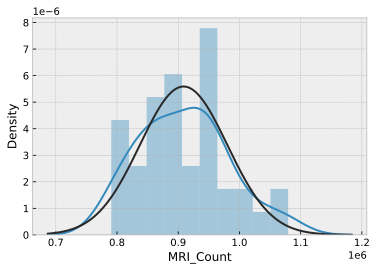

In [544]:
from scipy.stats import norm 

sns.distplot(brain_data['MRI_Count'], hist=True, bins=10, fit=norm)

Check whether the data comes from a normal distribution:

In [ ]:
print("Skewness coefficient {}: {:2.4f}".format('MRI_Count',brain_data['MRI_Count'].skew() ))
print("Kurtosis coefficient {}: {:2.4f}".format('MRI_Count',  brain_data['MRI_Count'].kurtosis()))

Skewness coefficient MRI_Count: 0.3702
Kurtosis coefficient MRI_Count: -0.2438


* *Skewness* shows how symmetrical the data is, from the value it is clear that the data is slightly offset, but not critical
* *Kurtosis* shows that the distribution is not strongly flattened, but has a small right tail.

Normality Test  

In [559]:

norm_test(brain_data['MRI_Count'])

stat=1.081, p=0.582
Probably Gaussian


**Conclusion**

* Higher the value of **p**, higher is the probability that the data is from a normal distribution. Apply a threshold (usually 0.05) above which the null hypothesis cannot be rejected. So, this distribution seems to be **normal**.

### **Distribution *FSIQ***

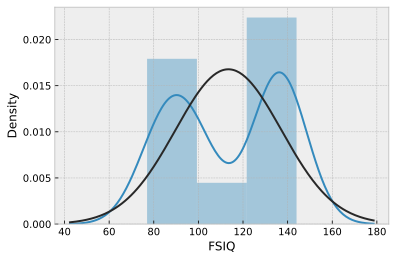

In [547]:
sns.distplot(brain_data['FSIQ'], hist=True, fit=norm);

Normality Test

In [560]:
norm_test(brain_data['FSIQ'])

stat=97.179, p=0.000
Probably not Gaussian


**Conclusion**  
* This distribution seems like **bimodal**.
* We have got two peaks of data, which usually indicates that there are two different groups. For example, IQ sometimes can fall into a bimodal distribution with a lot of people with a high score and a lot getting a low score. This can tell us that we are looking at two different groups of people. 

In [ ]:
def count_corr(data):
  intellig_n_brain_size = ['FSIQ', 'MRI_Count']
  needed_data = data.loc[:,intellig_n_brain_size]
  corr_matrix = needed_data.corr(method='spearman').round(4)
  return corr_matrix

### **I var. (both of men and women)**
* *Full Sqale IQ* - intelligence, а *MRI_Count* -  a brain size.

Evaluation of the pairwise dependencies of brain features.

### **Hypotheses**

In [ ]:
data_FSIQ = brain_data['FSIQ']
data_MRI_Count = brain_data['MRI_Count']

**Correlation Test**  

1) *Spearman’s Rank Correlation*

Tests whether two samples have a monotonic relationship.

*Assumptions*

Observations in each sample are independent and identically distributed (iid).
Observations in each sample can be ranked.

*Interpretation*

**H0:** the two samples are independent.  
**H1:** there is a dependency between the samples.

**Spearman’s Correlation**  

* Two variables may be related by a nonlinear relationship, such that the relationship is stronger or weaker across the distribution of the variables. 
* Our data seems to be not normal in connection to **FSIQ**. The two variables being considered may have a non-Gaussian distribution.

In [ ]:
from scipy.stats import spearmanr

# calculate spearman's correlation
corr, p = spearmanr(data_FSIQ, data_MRI_Count)
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.472


In [ ]:
#  Spearman's Rank Correlation Test
print('stat=%.3f, p=%.3f' % (corr, p), '\n')
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.472, p=0.002 

Probably dependent


* The data is not Gaussian and that the relationship between the variables is  not linear. Thus, the nonparametric rank-based approach shows a poor correlation between the variables of 0.47. 
* Moreover, we can observe, that these valiables **probably dependent** (p = 0.002).

In [ ]:
count_corr(brain_data)

,FSIQ,MRI_Count
FSIQ,1.0000,0.4721
MRI_Count,0.4721,1.0000


Text(0.5, 1.0, 'Correlation: Intelligence (FSIQ) & Brain size (MRI_Count)\n Both genders')

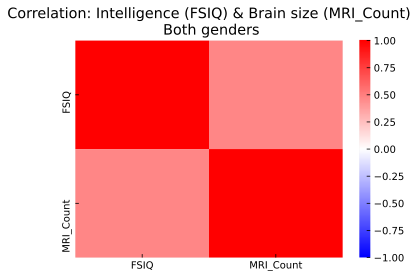

In [ ]:
ax = sns.heatmap(count_corr(brain_data), vmin=-1, vmax=1, cmap='bwr')
ax.set_title("Correlation: Intelligence (FSIQ) & Brain size (MRI_Count)\n Both genders")

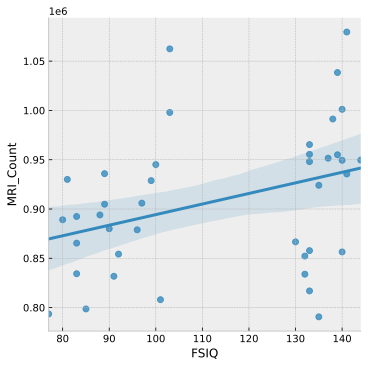

In [ ]:
sns.lmplot(x="FSIQ", y="MRI_Count", data=brain_data);

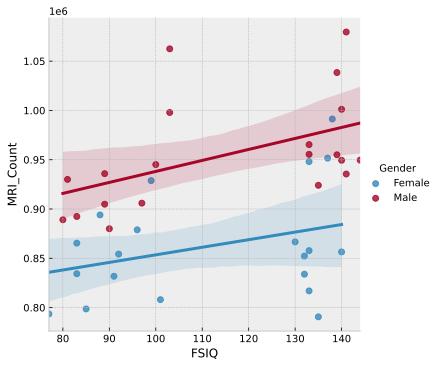

In [ ]:
sns.lmplot(x="FSIQ", y="MRI_Count", hue="Gender", data=brain_data);

**Conclusion**  
* There is a slight correlation between the brain size of both sexes and intelligence, since the correlation is close to 0, the coefficient is positive.
* It is obvious from the above scattering diagram that the relationship between intelligence and brain size is weakly linear.

### **II var. (separately men and women)**
* *Full Sqale IQ* - intelligence, а *MRI_Count* -  a brain size.

Evaluation of the pairwise dependencies of brain features.

### **Hypotheses**

***Men***

In [ ]:
mbr_data = brain_data[brain_data['Gender'] == 'Male']

In [ ]:
from scipy.stats import spearmanr

corr, p = spearmanr(mbr_data['FSIQ'], mbr_data['MRI_Count'])

print('stat=%.3f, p=%.3f' % (corr, p), '\n')
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.622, p=0.003 

Probably dependent


**Conclusion**  
* The data is not Gaussian and that the relationship between the variables is  not linear. Thus, the nonparametric rank-based approach shows a normal correlation between the variables of 0.62. 
* Moreover, we can observe, that these valiables **probably dependent** (p = 0.003 --> a little higher than for both genders - was 0.002) .


In [ ]:
count_corr(mbr_data)

,FSIQ,MRI_Count
FSIQ,1.0000,0.6225
MRI_Count,0.6225,1.0000


Text(0.5, 1.0, 'Correlation: Intelligence (FSIQ) & Brain size (MRI_Count)\n MEN')

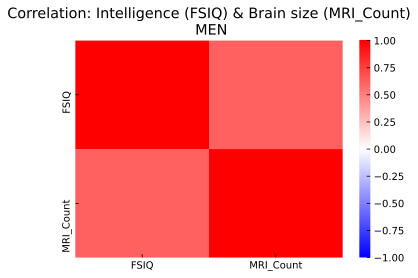

In [ ]:
ax = sns.heatmap(count_corr(mbr_data), vmin=-1, vmax=1, cmap='bwr')
ax.set_title("Correlation: Intelligence (FSIQ) & Brain size (MRI_Count)\n MEN")

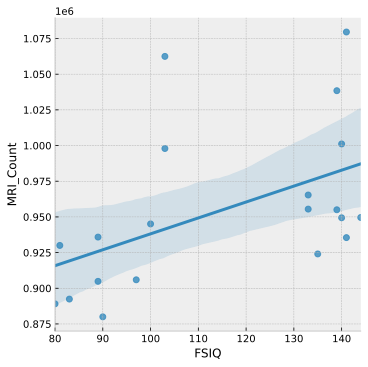

In [ ]:
sns.lmplot(x="FSIQ", y="MRI_Count", data=mbr_data);

**Conclusion**
* There is a correlation between the brain size of both sexes and intelligence, since the correlation is higher than 0.5, the coefficient is positive.
* It is obvious from the above scattering diagram that the relationship between intelligence and brain size is weakly linear.

### **Hypotheses**

***Women***

In [ ]:
fbr_data = brain_data[brain_data['Gender'] == 'Female']

In [ ]:
corr, p = spearmanr(fbr_data['FSIQ'], fbr_data['MRI_Count'])

print('stat=%.3f, p=%.3f' % (corr, p), '\n')
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.299, p=0.200 

Probably independent


**Conclusion**
* The data is not Gaussian and that the relationship between the variables is not linear. Thus, the nonparametric rank-based approach shows a poor correlation between the variables of 0.3. 
* Moreover, we can observe, that these valiables **probably dependent** (p = 0.2 --> strongly higher than for both genders or for men - were 0.002/0.003) .



In [ ]:
count_corr(fbr_data)

,FSIQ,MRI_Count
FSIQ,1.0000,0.2992
MRI_Count,0.2992,1.0000


Text(0.5, 1.0, 'Correlation: Intelligence (FSIQ) & Brain size (MRI_Count)\n WOMEN')

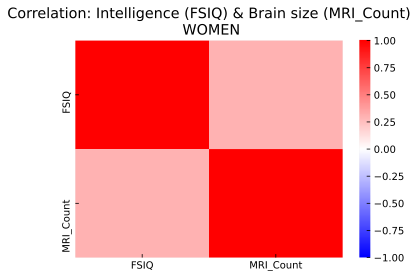

In [ ]:
ax = sns.heatmap(count_corr(fbr_data), vmin=-1, vmax=1, cmap='bwr')
ax.set_title("Correlation: Intelligence (FSIQ) & Brain size (MRI_Count)\n WOMEN")

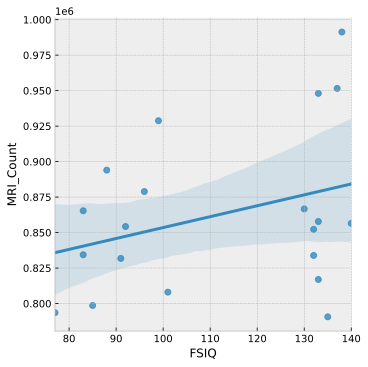

In [ ]:
sns.lmplot(x="FSIQ", y="MRI_Count", data=fbr_data);

**Conclusion**  
* There is a slight correlation between the brain size of both sexes and intelligence, since the correlation is close to 0, the coefficient is positive.
* It is obvious from the above scattering diagram that the relationship between intelligence and brain size is weakly linear.


**General conclusion**
* The biggest correlation between the brain size and intelligence has men (0.62). 
* This relationship between intelligence and brain size is weakly linear, we can observe it in each diagram.

### **Part 2**

In [ ]:
cars_prefes_data.head()

,ID,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,Reason,Cost,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
0,110,18,2,0,2,3,2,2,2,2,1,3,4,3,3,3,3,3,3,3,3,2
1,111,25,1,8,0,1,2,2,1,1,1,4,4,4,4,4,3,4,4,2,3,3
2,112,63,2,46,0,3,2,2,3,2,5,3,3,3,3,3,3,3,3,3,3,3
3,113,51,1,35,0,3,2,2,2,2,1,2,3,3,3,4,3,3,3,3,1,3
4,114,19,1,2,0,2,2,2,2,1,6,3,3,4,3,3,2,3,3,2,3,3


In [ ]:
cars_prefes_data.shape

(300, 22)

In [ ]:
cars_prefes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         300 non-null    int64
 1   Age        300 non-null    int64
 2   Sex        300 non-null    int64
 3   LicYr      300 non-null    int64
 4   LicMth     300 non-null    int64
 5   ActCar     300 non-null    int64
 6   Kids5      300 non-null    int64
 7   Kids6      300 non-null    int64
 8   PreferCar  300 non-null    int64
 9   Car15K     300 non-null    int64
 10  Reason     300 non-null    int64
 11  Cost       300 non-null    int64
 12  Reliable   300 non-null    int64
 13  Perform    300 non-null    int64
 14  Fuel       300 non-null    int64
 15  Safety     300 non-null    int64
 16  AC/PS      300 non-null    int64
 17  Park       300 non-null    int64
 18  Room       300 non-null    int64
 19  Doors      300 non-null    int64
 20  Prestige   300 non-null    int64
 21  Colour     300 n

In [ ]:
print('Unique Data\n')
for column in  cars_prefes_data.columns:
    print(f"{column}: --> {cars_prefes_data[column].unique()}\n")

Unique Data

ID: --> [110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130   1   2   3   4   5   7 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 149 150 151 152 153 156 241 242 243 245 246 248 249
   8  14  20  39  41  42  43  44  45  46  47  49  50  51 289 259 260 290
 261 292 296 270 297 276 277 299 278 300 279 280 281 282 301 302 304 305
 326 327 306 328 319 320 342 321 343 344 322 325 350 351 352 353 354 355
 368 363 371 364 365 372 366 373 374 375 376 381 379 382 157 158 159 160
 161 162 163 164 167 168 169 170 171 175 176 177 178 179 180 181 182 183
 184 185 186 187 189 190  52  55  58  60  63  65  67  68  69  70  71  72
  73  74 191 192 193 194 195 196 197 198 199 200 202 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 228 230
 233 235 236 238 239 240  75  76  77  78  79  80  81  83  84  85  86  87
  88  89  90  91  92  93  94 250 251 252 253 283 254 356 357 358 359 361
 367 362 383 380 384 385 386 3

* No missind values.

In [561]:
norm_test(cars_prefes_data["PreferCar"])

stat=11.741, p=0.003
Probably not Gaussian


**Pearson’s Chi-Squared test**

Tests whether two categorical variables are related or independent.

*Assumptions*

* Observations used in the calculation of the contingency table are independent.

*Interpretation*

**H0**: the two samples are independent.  
**H1**: there is a dependency between the samples.

In [ ]:
data = [cars_prefes_data["Sex"], cars_prefes_data["PreferCar"]]
headers = ["Sex", "PreferCar"]
df = pd.concat(data, axis=1, keys=headers)
df.head()

,Sex,PreferCar
0,2,2
1,1,1
2,2,3
3,1,2
4,1,2


 Contingency table

In [ ]:
x = pd.crosstab(df['Sex'], 
                df['PreferCar'])
display(x)

PreferCar,1,2,3,4
Sex,,,,
1,43,75,26,6
2,25,61,47,17


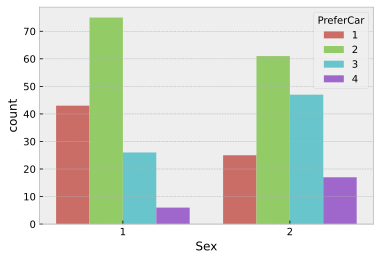

In [ ]:
sns.countplot(data=df, x="Sex", hue="PreferCar", palette="hls")

* Via plotting we can observe that both gengers prefer car № 2
* And both gengers don't like car № 4

**Null hypothesis (H0)** - the observed frequencies for a categorical variable match the expected frequencies for the categorical variable.

Calculate statistic and p-value for interpretation as well as the calculated degrees of freedom and table of expected frequencies:

In [ ]:
stat, p, dof, expected = chi2_contingency(x)
print('dof=%d' % dof)
print(expected)

dof=3
[[34.  68.  36.5 11.5]
 [34.  68.  36.5 11.5]]


In [ ]:
p

0.0005555699275518034

* A low P value suggests that your sample provides enough evidence that we can reject the null hypothesis for the entire population. 
Let's check it.

* **If Statistic >= Critical Value:** significant result, reject null hypothesis (H0), dependent.
* **If Statistic < Critical Value:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat),'\n')
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

probability=0.950, critical=7.815, stat=17.508 

Dependent (reject H0)


можно использовать вероятность 95%, предполагая, что результат теста весьма вероятен, учитывая предположение теста о том, что переменная независима. Если статистика меньше или равна критическому значению, мы можем не отвергнуть это предположение, в противном случае оно может быть отвергнуто.

*  **If p-value <= alpha:** significant result, reject null hypothesis (H0), dependent.
* **If p-value > alpha:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p), '\n')
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

significance=0.050, p=0.001 

Dependent (reject H0)


**Conclusion** 
* Degrees of freedom (dof) is reported as 3.
* Сalculated expected frequency table - we can see that indeed the observed contingency table does not match with crosstable.
* The critical value is calculated and interpreted, finding that indeed the variables are dependent (reject H0). The interpretation of the p-value makes the same finding.

# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

2) For 2016: divide countries into 3-4 groups according to the values of the **gdp_per_capita** feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/My Drive/DA/hw3/master.csv', sep=',')

In [ ]:
data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


## **Part 1**

In [ ]:
data['country'].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

### Сhoose a country
I take Germany

In [ ]:
df_germany = data[data['country'] == 'Germany']
df_germany.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
9710,Germany,1990,male,75+ years,1516,1717700,88.26,Germany1990,0.801,"1,764,967,948,917",23546,G.I. Generation
9711,Germany,1990,male,55-74 years,2406,6593100,36.49,Germany1990,0.801,"1,764,967,948,917",23546,G.I. Generation
9712,Germany,1990,male,35-54 years,3302,11127100,29.68,Germany1990,0.801,"1,764,967,948,917",23546,Silent


### Data description

In [ ]:
df_germany.shape

(312, 12)

In [ ]:
df_germany.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 9710 to 10021
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             312 non-null    object 
 1   year                312 non-null    int64  
 2   sex                 312 non-null    object 
 3   age                 312 non-null    object 
 4   suicides_no         312 non-null    int64  
 5   population          312 non-null    int64  
 6   suicides/100k pop   312 non-null    float64
 7   country-year        312 non-null    object 
 8   HDI for year        108 non-null    float64
 9    gdp_for_year ($)   312 non-null    object 
 10  gdp_per_capita ($)  312 non-null    int64  
 11  generation          312 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 31.7+ KB


In [ ]:
print('Unique Data\n')
for column in  df_germany.columns:
    print(f"{column}: --> {df_germany[column].unique()}\n")

Unique Data

country: --> ['Germany']

year: --> [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]

sex: --> ['male' 'female']

age: --> ['75+ years' '55-74 years' '35-54 years' '25-34 years' '15-24 years'
 '5-14 years']

suicides_no: --> [1516 2406 3302 1174 1488 1417  800 1128  434  228   22    9 1459 2445
 3427 1153 1523 1400  775 1200  411  185   27    5 1395 2405 1105 3250
 1576 1375  674 1093  384  163   26   12 1296 2485 3033  884 1467  632
 1009  371  157   47   13 1196 2527 3154  819 1541  682 1261  971  350
  170   30   17 1254 2597 3251 1452  630 1266  983  343  176   38   14
 1176 2463 3023  790 1441 1249  589  937  351   36 1135 2550 3177  802
 1345  600 1175  931  363  142   28    8 1126 2542 3039 1251  701 1048
  855  298  155   34   16 1045 2421 2863  749 1132  595  877  265  133
 1069 2528 2937  698 1002  575 1020  834  240  137   25 1106 2415 3060
  764  985  593  868  221  124   37   1

* The missing data is present in the column *HDI* in large quantities.

**The Human Development Index (HDI)** is a statistic composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which are used to rank countries into four tiers of human development.

* I think that it is worth creating a separate column - **is_HDI_missed** and see the dependence of deaths on this information.

In [ ]:
df_germany['is_HDI_missed'] = df_germany['HDI for year'].isnull().astype('int64')
df_germany.drop('HDI for year', axis=1, inplace=True)
df_germany.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation,is_HDI_missed
9710,Germany,1990,male,75+ years,1516,1717700,88.26,Germany1990,"1,764,967,948,917",23546,G.I. Generation,0
9711,Germany,1990,male,55-74 years,2406,6593100,36.49,Germany1990,"1,764,967,948,917",23546,G.I. Generation,0
9712,Germany,1990,male,35-54 years,3302,11127100,29.68,Germany1990,"1,764,967,948,917",23546,Silent,0


As already mentioned, there are many missing values for this feature in the data.

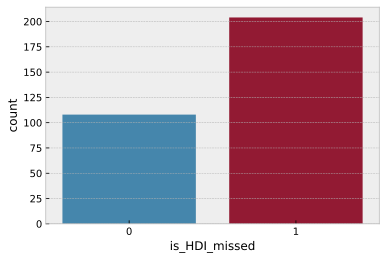

In [ ]:
sns.countplot(x='is_HDI_missed', 
              data=df_germany)


In [ ]:
HDI_missed = df_germany.groupby('is_HDI_missed').agg({'suicides_no':np.sum})
HDI_missed

,suicides_no
is_HDI_missed,
0,98542
1,192720


**Conclusion**  
* According to the data, it is clear that there are more people who have **committed suicide** and have an **unknown HDI**.

### **Task 1.**  
Visualize a feature **suicides_no** considering other features: 
* sex
* age (or generation) 
* year

**Sex**

In [ ]:
sex = df_germany.groupby('sex').agg({'suicides_no':np.sum})
sex

,suicides_no
sex,
female,79707
male,211555


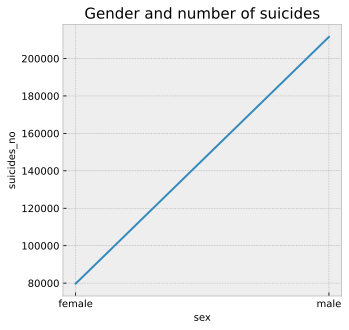

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax.set_xlabel('sex',fontsize=10)
ax.set_ylabel('suicides_no',fontsize=10)
ax.set_title('Gender and number of suicides',fontsize=15)
ax.plot(sex)

**Conclusion**
* Looking at the data, it is clear that **more men who committed suicide** are recorded in the data.

**Age**

In [ ]:
age = df_germany.groupby('age').agg({'suicides_no':np.sum})
age

,suicides_no
age,
15-24 years,17902
25-34 years,32947
35-54 years,97833
5-14 years,832
55-74 years,89191
75+ years,52557


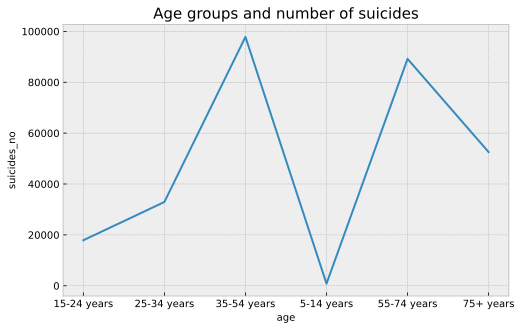

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('age',fontsize=10)
ax.set_ylabel('suicides_no',fontsize=10)
ax.set_title('Age groups and number of suicides',fontsize=15)
ax.plot(age)

**Conclusion**
* The group of people from 35 to 54 years old committed suicide the most (probably the midlife crisis could have affected) (~ 100,000)
* The group from 55 to 74 years old took the second place in committing suicide. (~ 90,000)
* The least number of suicides is observed in the age group-5-14 years. (~ 0)

**Generation**

In [ ]:
generation = df_germany.groupby('generation').agg({'suicides_no':np.sum})
generation

,suicides_no
generation,
Boomers,99684
G.I. Generation,27249
Generation X,47356
Generation Z,196
Millenials,14094
Silent,102683


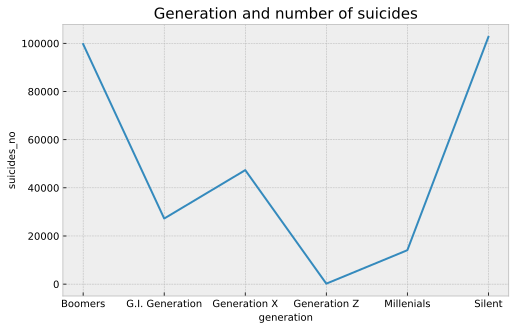

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('generation',fontsize=10)
ax.set_ylabel('suicides_no',fontsize=10)
ax.set_title('Generation and number of suicides',fontsize=15)
ax.plot(generation)

**Conclusion**
* The groups of people **Silent** (1928-1945) and **Boomers** (1946 - 1964) committed suicide very often  (~ 100,000)
* The least number of suicides is observed in the **Generation Z** group. (~ 0)

**Year**

In [ ]:
year = df_germany.groupby('year').agg({'suicides_no':np.sum})
year

,suicides_no
year,
1990,13924
1991,14010
1992,13458
1993,12690
1994,12718
1995,12888
1996,12225
1997,12256
1998,11654


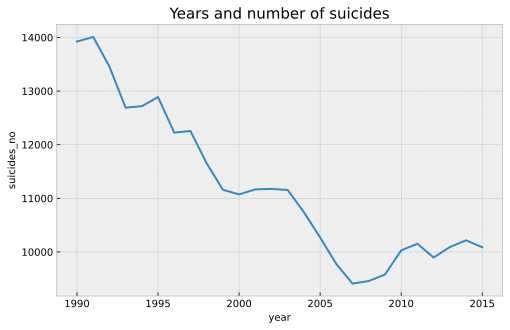

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('year',fontsize=10)
ax.set_ylabel('suicides_no',fontsize=10)
ax.set_title('Years and number of suicides',fontsize=15)
ax.plot(year)

**Conclusion**  
* The highest number of suicides occurred between 1990-1993. (~ 14000)
* Then suicides began to decline.
* The least number of suicides occurred in 2006-2007. ( > 10000)

### **Task 2.**  
Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

Distribution of **suicides_no** feature

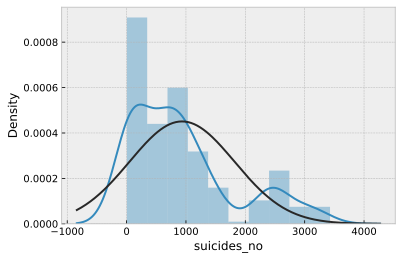

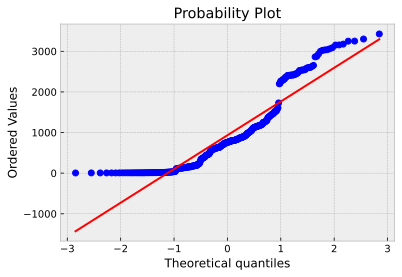

In [ ]:
from scipy import stats 
sns.distplot(df_germany['suicides_no'], hist=True, bins=10, fit=norm)
fig = plt.figure()
res = stats.probplot(df_germany['suicides_no'], plot=plt)

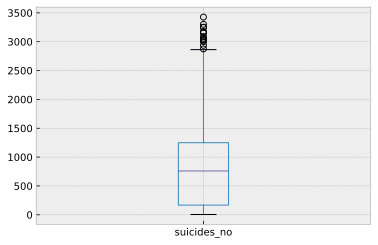

In [ ]:
df_germany.boxplot(column=['suicides_no'])

In [562]:
norm_test(df_germany["suicides_no"])

stat=43.680, p=0.000
Probably not Gaussian


*In the search for normality*  
* *'suicides_no'* is not normal. It shows nany peaks, positive skewness and does not follow the diagonal line.
* *Log norm* may try to improve this situation. 

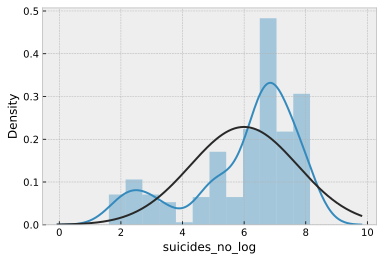

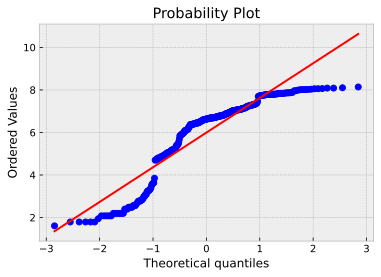

In [ ]:
from scipy import stats
df_germany['suicides_no_log'] = np.log(df_germany['suicides_no'])

sns.distplot(df_germany['suicides_no_log'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_germany['suicides_no_log'], plot=plt)

In [563]:
norm_test(df_germany["suicides_no_log"])

stat=43.823, p=0.000
Probably not Gaussian


* The distribution is still weakly similar to normal.

### **Men**

In [ ]:
mbr_data = df_germany[df_germany['sex'] == 'male']

**1) *Spearman’s Rank Correlation***

Tests whether two samples have a monotonic relationship.

*Assumptions*

Observations in each sample are independent and identically distributed (iid).
Observations in each sample can be ranked.

*Interpretation*

**H0:** the two samples are independent.  
**H1:** there is a dependency between the samples.

In [ ]:
from scipy.stats import spearmanr

corr, p = spearmanr(mbr_data['year'], mbr_data['suicides_no'])

print('Spearmans correlation = %.3f, p = %.3f' % (corr, p), '\n')
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

Spearmans correlation = -0.162, p = 0.043 

Probably dependent


**Conclusion**
* The data is not Gaussian and that the relationship between the variables is not linear. Thus, the nonparametric rank-based approach shows a very poor negative correlation between the variables of -0.162.
* Moreover, we can observe, that these valiables probably dependent (p = 0.043).

Text(0.5, 1.0, 'Correlation: Years & Suicides number \n Men')

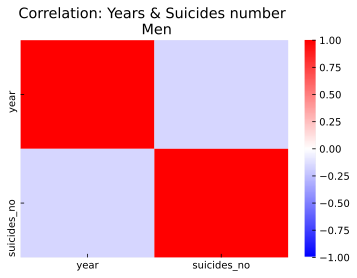

In [ ]:
year_n_suic_men = ['year', 'suicides_no']
needed_data = mbr_data.loc[:,year_n_suic_men]
corr_matrix_men = needed_data.corr(method='spearman').round(4)
ax = sns.heatmap(corr_matrix_men, vmin=-1, vmax=1, cmap='bwr')
ax.set_title("Correlation: Years & Suicides number \n Men")

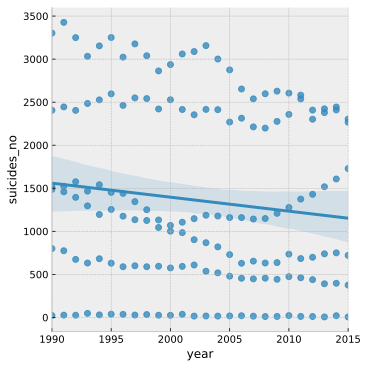

In [ ]:
sns.lmplot(x="year", y="suicides_no", data=mbr_data)

**Conclusion**
* There is a negative correlation between suicides number and year.
* It is obvious from the above scattering diagram that the relationship between intelligence and brain size is weakly linear.

***2) Pearson’s Chi-Squared test ('age' & 'suicides_no')***

Tests whether two categorical variables are related or independent.

*Assumptions*

* Observations used in the calculation of the contingency table are independent.

*Interpretation*

**H0**: the two samples are independent.  
**H1**: there is a dependency between the samples.

Contingency table

In [ ]:
x_men = pd.crosstab(mbr_data['age'], 
                mbr_data['suicides_no'])
display(x_men)

suicides_no,6,11,12,15,16,17,18,20,22,25,26,27,28,30,34,36,37,38,47,376,391,397,439,443,448,455,456,461,474,479,518,537,575,589,593,595,600,609,629,630,...,2406,2408,2410,2413,2415,2416,2421,2423,2444,2445,2463,2485,2527,2528,2538,2539,2542,2550,2582,2597,2598,2605,2628,2653,2863,2875,2937,3001,3023,3033,3039,3060,3088,3154,3157,3177,3250,3251,3302,3427
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15-24 years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25-34 years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35-54 years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5-14 years,2,2,2,1,2,1,1,2,2,1,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55-74 years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75+ years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Calculate statistic and p-value for interpretation as well as the calculated degrees of freedom and table of expected frequencies:

In [ ]:
stat, p, dof, expected = chi2_contingency(x_men)
print('dof=%d' % dof)
print(expected)

dof=725
[[0.33333333 0.33333333 0.33333333 0.16666667 0.33333333 0.16666667
  0.16666667 0.33333333 0.33333333 0.16666667 0.33333333 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.33333333 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.33333333 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.33333333 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.166

In [ ]:
p

0.10092174705050594

* A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis. This means we retain the null hypothesis and reject the alternative hypothesis.

* **If Statistic >= Critical Value:** significant result, reject null hypothesis (H0), dependent.
* **If Statistic < Critical Value:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat),'\n')
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

probability=0.950, critical=788.750, stat=774.000 

Independent (fail to reject H0)


* We can use a 95% probability, assuming that the test result is very likely, given the test assumption that the variable is independent. If the statistic is less than or equal to the critical value, we can not reject this assumption, otherwise it can be rejected.

*  **If p-value <= alpha:** significant result, reject null hypothesis (H0), dependent.
* **If p-value > alpha:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p), '\n')
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

significance=0.050, p=0.101 

Independent (fail to reject H0)


**Conclusion** 
* Degrees of freedom (dof) is reported as 725.
* The critical value is calculated and interpreted, finding that indeed the variables are Independent (fail to reject H0). The interpretation of the p-value makes the same finding.

***2) Pearson’s Chi-Squared test ('generation' & 'suicides_no')***  
Contingency table

In [ ]:
x_men_gen = pd.crosstab(mbr_data['generation'], 
                mbr_data['suicides_no'])
display(x_men_gen)

suicides_no,6,11,12,15,16,17,18,20,22,25,26,27,28,30,34,36,37,38,47,376,391,397,439,443,448,455,456,461,474,479,518,537,575,589,593,595,600,609,629,630,...,2406,2408,2410,2413,2415,2416,2421,2423,2444,2445,2463,2485,2527,2528,2538,2539,2542,2550,2582,2597,2598,2605,2628,2653,2863,2875,2937,3001,3023,3033,3039,3060,3088,3154,3157,3177,3250,3251,3302,3427
generation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Boomers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
G.I. Generation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Generation X,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,1,0,1,1,...,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Generation Z,2,2,2,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Millenials,0,0,0,0,2,1,1,1,0,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Silent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Calculate statistic and p-value for interpretation as well as the calculated degrees of freedom and table of expected frequencies:

In [ ]:
stat, p, dof, expected = chi2_contingency(x_men_gen)
print('dof=%d' % dof)
print(expected)

dof=725
[[0.37179487 0.37179487 0.37179487 0.18589744 0.37179487 0.18589744
  0.18589744 0.37179487 0.37179487 0.18589744 0.37179487 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.37179487 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.37179487 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.37179487 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.185

In [ ]:
p

0.19037820719681686

* A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis. This means we retain the null hypothesis and reject the alternative hypothesis.
* P-value is higher then prev. one (was 0.100)

* **If Statistic >= Critical Value:** significant result, reject null hypothesis (H0), dependent.
* **If Statistic < Critical Value:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat),'\n')
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

probability=0.950, critical=788.750, stat=758.206 

Independent (fail to reject H0)


* We can use a 95% probability, assuming that the test result is very likely, given the test assumption that the variable is independent. If the statistic is less than or equal to the critical value, we can not reject this assumption, otherwise it can be rejected.

*  **If p-value <= alpha:** significant result, reject null hypothesis (H0), dependent.
* **If p-value > alpha:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p), '\n')
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

significance=0.050, p=0.190 

Independent (fail to reject H0)


**Conclusion** 
* Degrees of freedom (dof) is reported as 725 as in prev.one.
* The critical value is calculated and interpreted, finding that indeed the variables are Independent (fail to reject H0). The interpretation of the p-value makes the same finding. It is bigger than in "age".

### **Women**

In [ ]:
fgerm_data = df_germany[df_germany['sex'] == 'female']

1) *Spearman’s Rank Correlation*

Tests whether two samples have a monotonic relationship.

*Assumptions*

Observations in each sample are independent and identically distributed (iid).
Observations in each sample can be ranked.

*Interpretation*

**H0:** the two samples are independent.  
**H1:** there is a dependency between the samples.

In [ ]:
corr, p = spearmanr(fgerm_data['year'], fgerm_data['suicides_no'])

print('Spearmans correlation = %.3f, p = %.3f' % (corr, p), '\n')
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

Spearmans correlation = -0.235, p = 0.003 

Probably dependent


**Conclusion**
* The data is not Gaussian and that the relationship between the variables is not linear. Thus, the nonparametric rank-based approach shows a very poor negative correlation between the variables of -0.235.
* Moreover, we can observe, that these valiables probably dependent (p = 0.003).   

Text(0.5, 1.0, 'Correlation: Years & Suicides number \n Women')

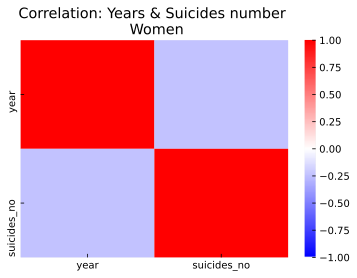

In [ ]:
year_n_suic_women = ['year', 'suicides_no']
needed_data = fgerm_data.loc[:,year_n_suic_women]
corr_matrix_men = needed_data.corr(method='spearman').round(4)
ax = sns.heatmap(corr_matrix_men, vmin=-1, vmax=1, cmap='bwr')
ax.set_title("Correlation: Years & Suicides number \n Women")

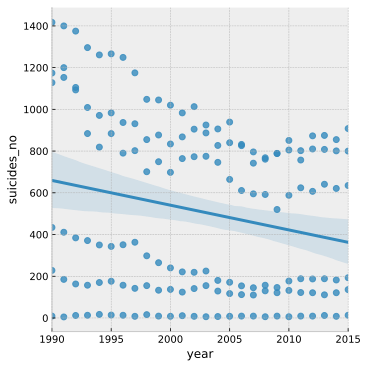

In [ ]:
sns.lmplot(x="year", y="suicides_no", data=fgerm_data)

**Conclusion**
* There is a negative correlation between suicides number and year.
* It is obvious from the above scattering diagram that the relationship between intelligence and brain size is weakly linear.

***2) Pearson’s Chi-Squared test ('age' & 'suicides_no')***

Tests whether two categorical variables are related or independent.

*Assumptions*

* Observations used in the calculation of the contingency table are independent.

*Interpretation*

**H0**: the two samples are independent.  
**H1**: there is a dependency between the samples.  

Contingency table

In [ ]:
x_women = pd.crosstab(fgerm_data['age'], 
                fgerm_data['suicides_no'])
display(x_women)

suicides_no,5,6,7,8,9,11,12,13,14,16,17,110,111,112,117,121,122,124,129,130,132,133,136,137,141,142,145,146,154,155,157,163,170,171,176,177,180,182,185,187,...,827,832,834,840,851,855,868,873,875,877,884,887,905,906,908,925,931,937,939,971,983,1009,1013,1020,1045,1048,1093,1105,1128,1153,1174,1175,1200,1249,1261,1266,1296,1375,1400,1417
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15-24 years,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,0,0,0,2,2,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25-34 years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35-54 years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
5-14 years,1,3,1,5,7,1,2,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55-74 years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0,0,0,0,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,0,0,1,0,1,1,1,1,1,1,1
75+ years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0


Calculate statistic and p-value for interpretation as well as the calculated degrees of freedom and table of expected frequencies:

In [ ]:
stat, p, dof, expected = chi2_contingency(x_women)
print('dof=%d' % dof)
print(expected)

dof=650
[[0.16666667 0.5        0.16666667 0.83333333 1.16666667 0.16666667
  0.33333333 0.5        0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.5        0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.33333333
  0.5        0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.33333333 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.33333333 0.16666667 0.166

In [ ]:
p

0.0028742400859308043

* A low P value suggests that your sample provides enough evidence that we can reject the null hypothesis for the entire population. 
Let's check it.

*  **If p-value <= alpha:** significant result, reject null hypothesis (H0), dependent.
* **If p-value > alpha:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p), '\n')
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

significance=0.050, p=0.003 

Dependent (reject H0)


**Conclusion** 
* Degrees of freedom (dof) is reported as 650.
* The critical value is calculated and interpreted, finding that indeed the variables are dependent (reject H0). The interpretation of the p-value makes the same finding.

***2) Pearson’s Chi-Squared test ('generation' & 'suicides_no')***  

Contingency table

In [ ]:
x_women_gen = pd.crosstab(fgerm_data['generation'], 
                fgerm_data['suicides_no'])
display(x_women_gen)

suicides_no,5,6,7,8,9,11,12,13,14,16,17,110,111,112,117,121,122,124,129,130,132,133,136,137,141,142,145,146,154,155,157,163,170,171,176,177,180,182,185,187,...,827,832,834,840,851,855,868,873,875,877,884,887,905,906,908,925,931,937,939,971,983,1009,1013,1020,1045,1048,1093,1105,1128,1153,1174,1175,1200,1249,1261,1266,1296,1375,1400,1417
generation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Boomers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,2,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
G.I. Generation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
Generation X,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,3,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Generation Z,0,2,0,1,4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Millenials,1,1,1,4,2,1,1,2,1,1,1,1,1,1,1,3,1,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Silent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0,1,0,1,1,1,1,1,1,0


Calculate statistic and p-value for interpretation as well as the calculated degrees of freedom and table of expected frequencies:

In [ ]:
stat, p, dof, expected = chi2_contingency(x_women_gen)
print('dof=%d' % dof)
print(expected)

dof=650
[[0.18589744 0.55769231 0.18589744 0.92948718 1.30128205 0.18589744
  0.37179487 0.55769231 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.55769231 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.37179487
  0.55769231 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.37179487 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.18589744 0.18589744 0.18589744 0.18589744 0.18589744
  0.18589744 0.37179487 0.18589744 0.185

In [ ]:
p

0.33709680640259937

* A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis. This means we retain the null hypothesis and reject the alternative hypothesis.
* P-value is higher then prev. one (was 0.002)

* **If Statistic >= Critical Value:** significant result, reject null hypothesis (H0), dependent.
* **If Statistic < Critical Value:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat),'\n')
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

probability=0.950, critical=710.421, stat=664.600 

Independent (fail to reject H0)


* We can use a 95% probability, assuming that the test result is very likely, given the test assumption that the variable is independent. If the statistic is less than or equal to the critical value, we can not reject this assumption, otherwise it can be rejected.

*  **If p-value <= alpha:** significant result, reject null hypothesis (H0), dependent.
* **If p-value > alpha:** not significant result, fail to reject null hypothesis (H0), independent.

In [ ]:
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p), '\n')
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

significance=0.050, p=0.337 

Independent (fail to reject H0)



**Conclusion** 
* Degrees of freedom (dof) is reported as 650.
* The critical value is calculated and interpreted, finding that indeed the variables are Independent (fail to reject H0). The interpretation of the p-value makes the same finding.

### **General conclusion**
*  For men and for women the two samples ('generation' and 'suicides_no') are independent.
* Men have higher DOF.
* For women the two samples ('age' and 'suicides_no') are dependent.

## **Part 2**

2) For 2016: divide countries into 3-4 groups according to the values of the gdp_per_capita feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

In [ ]:
df_2016 = data[data['year'] == 2016]
df_2016.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
1248,Armenia,2016,male,75+ years,12,61956,19.37,Armenia2016,NaN,"10,546,135,160",3788,Silent
1249,Armenia,2016,male,55-74 years,16,237813,6.73,Armenia2016,NaN,"10,546,135,160",3788,Boomers
1250,Armenia,2016,male,35-54 years,16,350633,4.56,Armenia2016,NaN,"10,546,135,160",3788,Generation X


In [ ]:
df_2016.rename(columns={'gdp_per_capita ($)': 'gdp_per_capita'}, inplace=True)
df_2016.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita', 'generation'],
      dtype='object')

In [ ]:
df_2016.shape

(160, 12)

In [ ]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 1248 to 25311
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             160 non-null    object 
 1   year                160 non-null    int64  
 2   sex                 160 non-null    object 
 3   age                 160 non-null    object 
 4   suicides_no         160 non-null    int64  
 5   population          160 non-null    int64  
 6   suicides/100k pop   160 non-null    float64
 7   country-year        160 non-null    object 
 8   HDI for year        0 non-null      float64
 9    gdp_for_year ($)   160 non-null    object 
 10  gdp_per_capita      160 non-null    int64  
 11  generation          160 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 16.2+ KB


* *HDI for year* feature has only *NaN* values. So, I have to delete tis column.

In [ ]:
df_2016.drop(['HDI for year'], axis=1, inplace=True)
df_2016.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita,generation
1248,Armenia,2016,male,75+ years,12,61956,19.37,Armenia2016,"10,546,135,160",3788,Silent
1249,Armenia,2016,male,55-74 years,16,237813,6.73,Armenia2016,"10,546,135,160",3788,Boomers
1250,Armenia,2016,male,35-54 years,16,350633,4.56,Armenia2016,"10,546,135,160",3788,Generation X


In [ ]:
!pip install researchpy 

In [ ]:
import researchpy as rp

In [ ]:
rp.summary_cont(df_2016['gdp_per_capita'].groupby(df_2016['country']))

,N,Mean,SD,SE,95% Conf.,Interval
country,,,,,,
Armenia,10,3788,0.0,0.0,NaN,NaN
Austria,10,46976,0.0,0.0,NaN,NaN
Croatia,10,12905,0.0,0.0,NaN,NaN
Cyprus,10,25098,0.0,0.0,NaN,NaN
Czech Republic,10,19505,0.0,0.0,NaN,NaN
Grenada,10,10838,0.0,0.0,NaN,NaN
Hungary,10,13448,0.0,0.0,NaN,NaN
Iceland,10,64708,0.0,0.0,NaN,NaN
Lithuania,10,15742,0.0,0.0,NaN,NaN


In [ ]:
gdp_mean_by_country = pd.DataFrame(df_2016.groupby(['country'])['gdp_per_capita'].mean())
gdp_mean_by_country = gdp_mean_by_country.sort_values(by='gdp_per_capita', ascending=False)
gdp_mean_by_country

,gdp_per_capita
country,
Iceland,64708
Qatar,62484
Sweden,55594
Netherlands,48108
Austria,46976
Cyprus,25098
Czech Republic,19505
Lithuania,15742
Hungary,13448


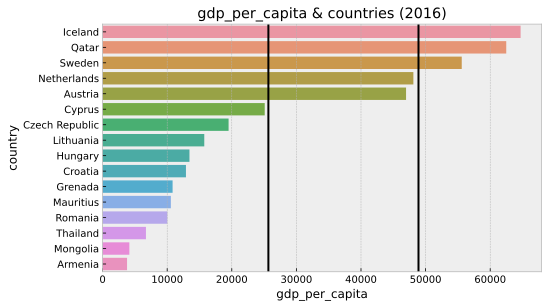

In [ ]:
suicide_country = df_2016.groupby('country').mean().sort_values('gdp_per_capita', ascending=False).reset_index()

plt.figure(figsize=(14,8))
plt.subplot(221)
sns.barplot(x='gdp_per_capita',y='country',data=suicide_country)
plt.axvline(x=suicide_country['gdp_per_capita'].mean(), color='k')
plt.axvline(x=48900, color='k') 
plt.gca().xaxis.tick_bottom()
plt.title('gdp_per_capita & countries (2016)')

plt.tight_layout()

* It seems to me that it is worth highlighting **3 groups** of countries.


* **Group 1:** from 0 to 25000
* **Group 2:** from 2500 to 48900
* **Group 3:** from 48900 to 60000+

* It can be noted that **Iceland, Qatar and Sweden** show **the highest GDP per capit**, which is an important economic indicator of material well-being in a country or region.
* While **Mongolia And Armenia** are **at the bottom of the rating**.

In [ ]:
gr1 = df_2016[(df_2016['country'] == 'Iceland') | (df_2016['country'] == 'Qatar') | (df_2016['country'] =='Sweden')]

gr2 = df_2016[(df_2016['country'] == 'Netherlands') | (df_2016['country'] == 'Austria')]

gr3 = df_2016[(df_2016['country'] == 'Czech Republic') | (df_2016['country'] == 'Cyprus') |
              (df_2016['country'] == 'Lithuania') | (df_2016['country'] == 'Hungary') |
              (df_2016['country'] == 'Croatia') | (df_2016['country'] == 'Grenada') |
               (df_2016['country'] == 'Mauritius') | (df_2016['country'] == 'Romania') |
               (df_2016['country'] == 'Thailand') | (df_2016['country'] == 'Mongolia') |
              (df_2016['country'] == 'Armenia')]

In [ ]:
def plot_gr_suicides_100kpop(data, num):
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    sns.barplot(x='suicides/100k pop', y='country',data=data)
    plt.gca().xaxis.tick_bottom()
    plt.title(f'Suicides(100k) of population by Country \n Group {num}')
    plt.tight_layout()
    
    plt.subplot(222)
    sns.boxplot(data['suicides/100k pop'])

**1st group**

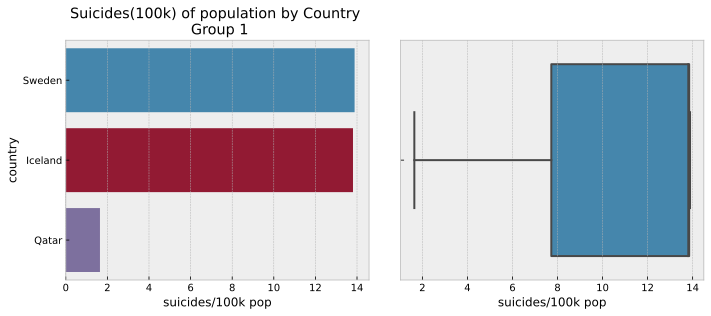

In [ ]:
gr1_suic_100k = gr1.groupby('country').mean().sort_values('suicides/100k pop', ascending=False).reset_index()
plot_gr_suicides_100kpop(gr1_suic_100k, 1)

In [ ]:
gr1['suicides/100k pop'].mean()

9.777999999999999

* The average suicide rate per 100k people in the population of 1 groups is 10 people.

In [ ]:
gr1.groupby(['age'])['suicides/100k pop'].sum()

age
15-24 years    47.19
25-34 years    68.76
35-54 years    60.58
55-74 years    68.41
75+ years      48.40
Name: suicides/100k pop, dtype: float64

Text(0.5, 1.0, 'average of suicides by age')

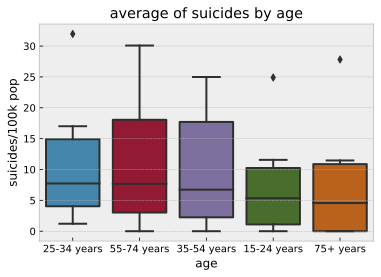

In [ ]:
ax = sns.boxplot(x='age',y='suicides/100k pop', data=gr1)
ax.set_title('average of suicides by age')

* The majority of people who commit suicide on average are in the age range of 55-74.
* The number of suicides is higher in the age group 55-74
* The least number of people commit suicide at the age of 15-24 years and 75+.


In [ ]:
gr1.groupby(['sex'])['suicides/100k pop'].sum()

sex
female     58.58
male      234.76
Name: suicides/100k pop, dtype: float64

Text(0.5, 1.0, 'average of suicides by sex')

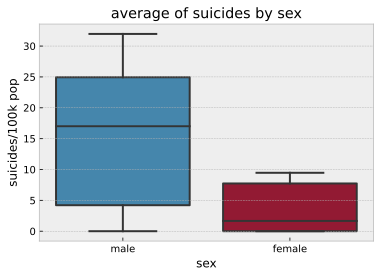

In [ ]:
ax = sns.boxplot(x='sex',y='suicides/100k pop', data=gr1)
ax.set_title('average of suicides by sex')

* The majority of people who commit suicide on average are men.


In [ ]:
print('average of suicides by sex & age')
gr1.groupby(['sex', 'age'])['suicides/100k pop'].mean()

average of suicides by sex & age


sex     age        
female  15-24 years     2.100000
        25-34 years     5.560000
        35-54 years     3.710000
        55-74 years     5.116667
        75+ years       3.040000
male    15-24 years    13.630000
        25-34 years    17.360000
        35-54 years    16.483333
        55-74 years    17.686667
        75+ years      13.093333
Name: suicides/100k pop, dtype: float64

**Conclusion**
* In group 2, the number of suicides among men and the suicide rate is much higher than among women.
* When adding an age, the results remain the same.
* The age groups of 15-24 and 75+ are the least likely to commit suicide.
* Both sexes in the age group of 55-74 are more likely to commit suicide.


**2nd group**

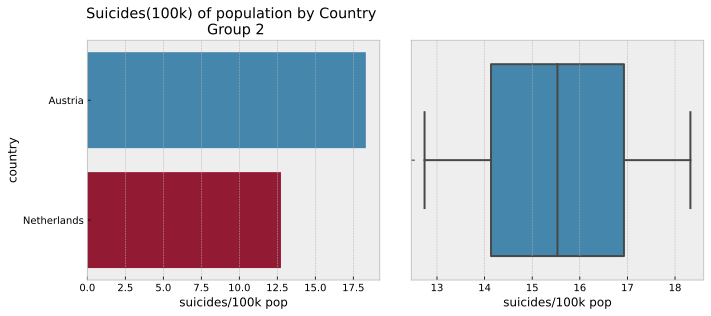

In [ ]:
gr2_suic_100k= gr2.groupby('country').mean().sort_values('suicides/100k pop', ascending=False).reset_index()

plot_gr_suicides_100kpop(gr2_suic_100k, 2)

In [ ]:
gr2['suicides/100k pop'].mean()

15.531

* The average suicide rate per 100k people in the population of 2 groups is 16 people.

In [ ]:
gr2.groupby(['age'])['suicides/100k pop'].sum()

age
15-24 years     26.16
25-34 years     38.46
35-54 years     57.45
55-74 years     73.04
75+ years      115.51
Name: suicides/100k pop, dtype: float64

Text(0.5, 1.0, 'average of suicides by age')

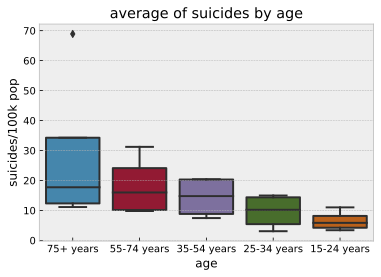

In [ ]:
ax = sns.boxplot(x='age',y='suicides/100k pop', data=gr2)
ax.set_title('average of suicides by age')

* The majority of people who commit suicide on average are in the age range of 75+.
* The number of suicides is higher in the age group 75+
* The least number of people commit suicide at the age of 15-24 years.


In [ ]:
gr2.groupby(['sex'])['suicides/100k pop'].sum()

sex
female     77.93
male      232.69
Name: suicides/100k pop, dtype: float64

Text(0.5, 1.0, 'average of suicides by sex')

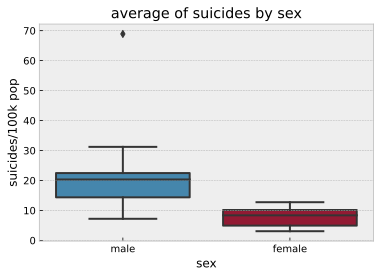

In [ ]:
ax = sns.boxplot(x='sex',y='suicides/100k pop', data=gr2)
ax.set_title('average of suicides by sex')

* The majority of people who commit suicide on average are men.
* Women are less represented in this group.


In [ ]:
print('average of suicides by sex & age')
gr2.groupby(['sex', 'age'])['suicides/100k pop'].mean()

average of suicides by sex & age


sex     age        
female  15-24 years     3.960
        25-34 years     4.650
        35-54 years     8.375
        55-74 years    10.035
        75+ years      11.945
male    15-24 years     9.120
        25-34 years    14.580
        35-54 years    20.350
        55-74 years    26.485
        75+ years      45.810
Name: suicides/100k pop, dtype: float64

**Conclusion**
* In group 2, the number of suicides among men and the suicide rate is much higher than among women.
* When adding an age, the results remain the same.
* The age group of 15-24 is the least likely to commit suicide especially women.
* Both sexes in the age group of 75+ are more likely to commit suicide.


**3d group**

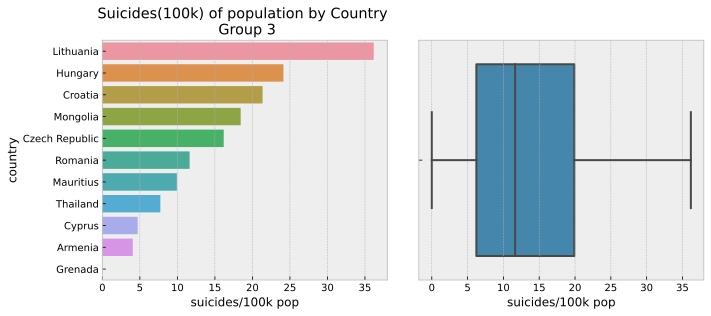

In [ ]:
gr3_suic_100k= gr3.groupby('country').mean().sort_values('suicides/100k pop', ascending=False).reset_index()

plot_gr_suicides_100kpop(gr3_suic_100k, 3)

In [ ]:
gr3['suicides/100k pop'].mean()

14.031181818181818

* The average suicide rate per 100k people in the population of 3 groups is 15 people.



In [ ]:
gr3.groupby(['age'])['suicides/100k pop'].sum()

age
15-24 years    166.73
25-34 years    224.70
35-54 years    307.52
55-74 years    339.57
75+ years      504.91
Name: suicides/100k pop, dtype: float64

Text(0.5, 1.0, 'average of suicides by age')

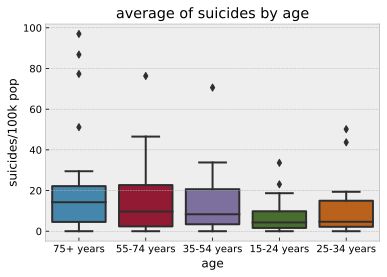

In [ ]:
ax =sns.boxplot(x='age',y='suicides/100k pop', data=gr3)
ax.set_title('average of suicides by age')

* The majority of people who commit suicide on average are in the age range of 75+.
* The number of suicides is higher in the age group 55-74
* The least number of people commit suicide at the age of 15-24 years.

In [ ]:
gr3.groupby(['sex'])['suicides/100k pop'].sum()

sex
female     248.98
male      1294.45
Name: suicides/100k pop, dtype: float64

Text(0.5, 1.0, 'average of suicides by sex')

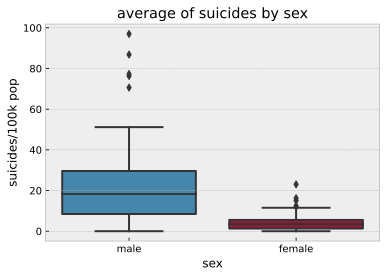

In [ ]:
ax = sns.boxplot(x='sex',y='suicides/100k pop', data=gr3)
ax.set_title('average of suicides by sex')

* The majority of people who commit suicide on average are men.
* Women are less represented in this group.

In [ ]:
print('average of suicides by sex & age')
gr3.groupby(['sex', 'age'])['suicides/100k pop'].mean()

average of suicides by sex & age


sex     age        
female  15-24 years     2.533636
        25-34 years     2.898182
        35-54 years     4.542727
        55-74 years     5.085455
        75+ years       7.574545
male    15-24 years    12.623636
        25-34 years    17.529091
        35-54 years    23.413636
        55-74 years    25.784545
        75+ years      38.326364
Name: suicides/100k pop, dtype: float64

**Conclusion**  
* In group 3, the number of suicides among men and the suicide rate is much higher than among women.
* When adding an age, the results remain the same.
* The age group of 15-24 is the least likely to commit suicide.
* Both sexes in the age group of 75+ are more likely to commit suicide.

***General conclusion*** 
* **Group 1:**
  - The lowest average number of suicides per 100k.
  - Here, the age group from 55 to 74 years is more susceptible to suicide.
  - More men are dying.

* **Group 2:**
  - The highest average value of suicides per 100k.
  - The age category of 75+is more susceptible to suicide here.
  - More men are dying.

* **Group 3:**
  - There are more countries in Group 3, but the level of GDP per capita there is much lower.
  - Men aged 75+commit suicide the most.
  - More men are dying.

### **Hypotheses**


**I hypothesis**
* **H0:** There is no significant difference between the suicide rates in 1 and 2.
* **H1:** There is a significant difference between the suicide rates in 1 and 2.

* I take random samples of 20 data points from group.

In [ ]:
gr1_sample = gr1.sample(20)
gr3_sample = gr2.sample(20)

* Then I take only 'suicides/100k pop' feature.

In [ ]:
s1 = np.array(gr1_sample['suicides/100k pop'])
print(s1)
 
median1 = np.median(s1)
print('MEDIAN1a =',median1)

[30.08  8.61  9.28  9.46  1.21  6.86 24.9   0.    0.    0.    4.43  4.
 24.99 11.56 17.01  0.    0.   27.82  0.    0.  ]
MEDIAN1a = 5.645


In [ ]:
s2 = np.array(gr2_sample['suicides/100k pop'])
print(s2)

median2 = np.median(s2)
print('MEDIAN2 =',median2)

[ 0.    4.38  6.11  2.55 31.27  3.69  0.   76.32 19.37  0.    2.13  0.
  1.56 10.21 25.54 29.49  7.29 10.09  0.    1.95]
MEDIAN2 = 4.035


* It is clear that the average suicide rates in the samples from the two groups differ significantly. 

The calculation of the value of the test statistics:

In [ ]:
TS= median1-median2
print("Test Statistic is (Median of 1st group - Median of 3d group)=", TS)

Test Statistic is (Median of 1st group - Median of 3d group)= -6.870000000000001


* Next step - concatenation of two sets of sample data into one set and shuffling them, so that observations of both sets are mixed properly into one single set.

In [ ]:
samp = np.concatenate((s1,s2), axis=None)
np.random.shuffle(samp)
print(samp)

[11.14 31.22  7.46 20.29  3.11 10.26  9.12  0.    9.46 31.96  1.67 21.75
 22.72  1.21 12.75  0.    4.51  9.81 11.03  7.21 20.97  3.07  9.29  4.43
  2.01 24.9   0.   11.46 14.97  0.    9.28  3.41  6.23 20.41 14.19  0.
 68.9  27.82  4.   24.99]


* We perform re-sampling 1000 times by taking two samples sets of 20 points and calculate the difference of their medians each time. The list of median differences are stored in another numpy array.

In [ ]:
median_lst=np.zeros(1000)
for i in range(1000):
    _s1= np.random.choice(samp,20)
    _s2= np.setdiff1d(samp, _s1)
    _median1= np.median(_s1)
    _median2= np.median(_s2)
    median_lst[i]= np.array(_median1 - _median2)

* Finale, the medianlist is sorted in ascending order and p-value is calculated.

In [ ]:
median_lst = np.sort(median_lst)
#calculation of p-value
ct=0
for i in median_lst:
    if i < TS:
        ct += 1
p_val = (1000-ct) / 1000
median_lst = pd.DataFrame(median_lst, columns=['mediandiff'])
pv95 = median_lst.mediandiff[949]

print('VALUE in 95th Percentile position=', pv95)
print('TEST STATISTIC =',TS)
print('P-VALUE OF TS =', p_val)

VALUE in 95th Percentile position= 4.35
TEST STATISTIC = -6.870000000000001
P-VALUE OF TS = 0.956


In [ ]:
if p_val > 0.05:
    print('Observation value  < 95 percentile.\nThus the probability of occurrence of our observations given\nnull hypothesis is high as P-value of {} is higher than the significance level of 0.05'.format(pvalue))
    print('H0 - true: 1st & 2nd groups have NO significant difference in suicide rates. ')
else:
    print('Observation value is > 95 percentile.\n Thus the probability of occurrence of our observation given null hypothesis is extremely low, as P-value of {} is lower than the significance level of 0.05'.format(pvalue))
    print('We reject H0 and accept H1: 1st group and 2nd group have a significant difference in suicide rates')
    if TS > 0:
        print('from the sign of TS we know 1st group has a higher suicide rate.')
    else:
        print('from the sign of TS we know 2nd group has a higher suicide rate.')

Observation value  < 95 percentile.
Thus the probability of occurrence of our observations given
null hypothesis is high as P-value of 0.961 is higher than the significance level of 0.05
H0 - true: 1st & 2nd groups have NO significant difference in suicide rates. 


**Conclusion**  
* A p-Value of 0.956 means that there is a probability of almost 96% that our sample observations will occur given that there is no significant difference between suicide rates in 1st and 3d groups, which is much higher than 5% significance level. Thus we accept our H0 as True.

**II hypothesis**
* **H0:** There is no significant difference between the suicide rates in 1 and 3.
* **H1:** There is a significant difference between the suicide rates in 1 and 3.


* I take random samples of 20 data points from group.

In [ ]:
gr2_sample = gr1.sample(20)
gr3_sample = gr3.sample(20)

* Then I take only 'suicides/100k pop' feature.

In [ ]:
s1 = np.array(gr1_sample['suicides/100k pop'])
print(s1)
 
median1 = np.median(s1)
print('MEDIAN1 =',median1)

[30.08  8.61  9.28  9.46  1.21  6.86 24.9   0.    0.    0.    4.43  4.
 24.99 11.56 17.01  0.    0.   27.82  0.    0.  ]
MEDIAN1 = 5.645


In [ ]:
s2 = np.array(gr3_sample['suicides/100k pop'])
print(s2)

median2 = np.median(s2)
print('MEDIAN2 =',median2)

[ 3.5  96.98  5.9  31.27 46.51  4.98 50.17 14.09  6.33 77.31 15.48 18.28
  2.47 19.37 76.32  4.26  6.11  0.   38.94  0.  ]
MEDIAN2 = 14.785


* It is clear that the average suicide rates in the samples from the two groups differ significantly.  

The calculation of the value of the test statistics:

In [ ]:
TS= median1-median2
print("Test Statistic is (Median of 1st group - Median of 3d group)=", TS)

Test Statistic is (Median of 1st group - Median of 3d group)= -9.14


* Next step - concatenation of two sets of sample data into one set and shuffling them, so that observations of both sets are mixed properly into one single set.

In [ ]:
samp = np.concatenate((s1,s2), axis=None)
np.random.shuffle(samp)
print(samp)

[ 4.98  0.    4.26  9.46  5.9   4.   17.01  9.28  0.    0.    0.   30.08
  0.   11.56  6.33  1.21 19.37 24.99  8.61  0.   96.98 14.09  6.86 18.28
  6.11  3.5  50.17 38.94 15.48 24.9  77.31  0.   31.27  2.47 76.32  0.
 27.82  4.43 46.51  0.  ]


* We perform re-sampling 1000 times by taking two samples sets of 20 points and calculate the difference of their medians each time. The list of median differences are stored in another numpy array.

In [ ]:
median_lst=np.zeros(1000)
for i in range(1000):
    _s1= np.random.choice(samp,20)
    _s2= np.setdiff1d(samp, _s1)
    _median1= np.median(_s1)
    _median2= np.median(_s2)
    median_lst[i]= np.array(_median1 - _median2)

* Finale, the medianlist is sorted in ascending order and p-value is calculated.

In [ ]:
median_lst = np.sort(median_lst)
#calculation of p-value
ct=0
for i in median_lst:
    if i < TS:
        ct += 1
p_val = (1000-ct) / 1000
median_lst = pd.DataFrame(median_lst, columns=['mediandiff'])
pv95 = median_lst.mediandiff[949]

print('VALUE in 95th Percentile position=', pv95)
print('TEST STATISTIC =',TS)
print('P-VALUE OF TS =', p_val)

VALUE in 95th Percentile position= 8.275000000000002
TEST STATISTIC = -9.14
P-VALUE OF TS = 0.698


In [ ]:
if p_val > 0.05:
    print('Observation value  < 95 percentile.\nThus the probability of occurrence of our observations given\nnull hypothesis is high as P-value of {} is higher than the significance level of 0.05'.format(pvalue))
    print('H0 - true: 1st & 3d groups have NO significant difference in suicide rates. ')
else:
    print('Observation value is > 95 percentile.\n Thus the probability of occurrence of our observation given null hypothesis is extremely low, as P-value of {} is lower than the significance level of 0.05'.format(pvalue))
    print('We reject H0 and accept H1: 1st group and 3d group have a significant difference in suicide rates')
    if TS > 0:
        print('from the sign of TS we know 1st group has a higher suicide rate.')
    else:
        print('from the sign of TS we know 3d group has a higher suicide rate.')


Observation value  < 95 percentile.
Thus the probability of occurrence of our observations given
null hypothesis is high as P-value of 0.961 is higher than the significance level of 0.05
H0 - true: 1st & 3d groups have NO significant difference in suicide rates. 


* A p-Value of 0.698 means that there is a probability of almost 96% that our sample observations will occur given that there is no significant difference between suicide rates in 1st and 3d groups, which is much higher than 5% significance level. Thus we accept our H0 as True.


**III hypothesis**
* **H0:** There is no significant difference between the suicide rates in 2 and 3.
* **H1:** There is a significant difference between the suicide rates in 2 and 3.


* I take random samples of 20 data points from group.

In [ ]:
gr2_sample = gr2.sample(20)
gr3_sample = gr3.sample(20)


* Then I take only 'suicides/100k pop' feature.

In [ ]:
s1 = np.array(gr2_sample['suicides/100k pop'])
print(s1)
 
median1 = np.median(s1)
print('MEDIAN1a =',median1)


[11.03 10.26 21.75  3.41  9.81  7.46 12.75  4.51 11.14 22.72  9.29 14.97
 20.41  3.07 68.9   6.23  7.21 20.29 14.19 31.22]
MEDIAN1a = 11.085


In [ ]:
s2 = np.array(gr3_sample['suicides/100k pop'])
print(s2)

median2 = np.median(s2)
print('MEDIAN2 =',median2)


[ 0.    1.56 21.46 13.52 10.09  6.8   4.98  8.24 33.81  1.4  46.51 14.1
  0.   15.03 25.57  4.34  0.   17.49 18.28  0.  ]
MEDIAN2 = 9.165


* It is clear that the average suicide rates in the samples from the two groups similar to each other.  

The calculation of the value of the test statistics:


In [ ]:
TS= median1-median2
print("Test Statistic is (Median of 2nd group - Median of 3d group)=", TS)

Test Statistic is (Median of 2nd group - Median of 3d group)= 1.9200000000000017


* Next step - concatenation of two sets of sample data into one set and shuffling them, so that observations of both sets are mixed properly into one single set.

In [ ]:
samp = np.concatenate((s1,s2), axis=None)
np.random.shuffle(samp)
print(samp)


[ 0.   15.03 33.81  4.98  8.24 25.57 22.72  1.4   9.29 21.75 14.19 17.49
  0.   13.52 68.9   7.21 11.14 31.22  3.41 14.1   4.34 18.28  6.8  11.03
  4.51  7.46  3.07  0.    6.23 14.97  9.81 21.46 10.09 12.75  0.   10.26
  1.56 46.51 20.29 20.41]


* We perform re-sampling 1000 times by taking two samples sets of 20 points and calculate the difference of their medians each time. The list of median differences are stored in another numpy array.

In [ ]:
median_lst=np.zeros(1000)
for i in range(1000):
    _s1= np.random.choice(samp,20)
    _s2= np.setdiff1d(samp, _s1)
    _median1= np.median(_s1)
    _median2= np.median(_s2)
    median_lst[i]= np.array(_median1 - _median2)


* Finale, the medianlist is sorted in ascending order and p-value is calculated.

In [ ]:
median_lst = np.sort(median_lst)
#calculation of p-value
ct=0
for i in median_lst:
    if i < TS:
        ct += 1
p_val = (1000-ct) / 1000
median_lst = pd.DataFrame(median_lst, columns=['mediandiff'])
pv95 = median_lst.mediandiff[949]

print('VALUE in 95th Percentile position=', pv95)
print('TEST STATISTIC =',TS)
print('P-VALUE OF TS =', p_val)


VALUE in 95th Percentile position= 5.245000000000001
TEST STATISTIC = 1.9200000000000017
P-VALUE OF TS = 0.272


In [ ]:
if p_val > 0.05:
    print('Observation value  < 95 percentile.\nThus the probability of occurrence of our observations given\nnull hypothesis is high as P-value of {} is higher than the significance level of 0.05'.format(pvalue))
    print('H0 - true: 1st & 3d groups have NO significant difference in suicide rates. ')
else:
    print('Observation value is > 95 percentile.\n Thus the probability of occurrence of our observation given null hypothesis is extremely low, as P-value of {} is lower than the significance level of 0.05'.format(pvalue))
    print('We reject H0 and accept H1: 1st group and 3d group have a significant difference in suicide rates')
    if TS > 0:
        print('from the sign of TS we know 1st group has a higher suicide rate.')
    else:
        print('from the sign of TS we know 3d group has a higher suicide rate.')

Observation value  < 95 percentile.
Thus the probability of occurrence of our observations given
null hypothesis is high as P-value of 0.961 is higher than the significance level of 0.05
H0 - true: 1st & 3d groups have NO significant difference in suicide rates. 


**Conclusion**  
* A p-Value of 0.272 means that there is a probability of almost 27% that our sample observations will occur given that there is no significant difference between suicide rates in 2 and 3d groups, however it is not higher than 5% significance level. But we accept our H0 as True.
